# Fiber Bundle Models

## Strain-controlled

Strain controlled FBM with constant failure stress

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def FBM2C(stiffness_ratio, strength_ratio, volume_fraction, **kwds): 
    """
    Run a dimensionless 2-component fibre bundle model with global load sharing.

    **Arguments**:
     - the stiffness ratio of component A and B
     - the strength ratio of component A and B
     - the volume fraction of component A

    **Keywords**:
     - r = The strain-rate
     - N = the number of fibres in the bundle
     - k = the shape parameter of the Weibul distribution to sample fibre strength from. 
    **Returns**:
     - stress = the (non-dimensional) bulk stress
     - strain = the (non-dimensional) strain
     - ae_A = the number of failures of material A
     - ae_B = the number of failures of material B
    """
    
    #get kwds
    r = kwds.get("r",0.01)
    N = kwds.get("N",10000)
    nA = int(N*volume_fraction) #number of fibres of type A
    k = kwds.get("k",10)

    #generate stiffness population
    stiffness = np.hstack([  [stiffness_ratio]*nA, #A-type fibers
                             [1.0]*(N-nA)]  )     #B-type fibers
    
    #generate strength population
    strength = np.hstack([  np.random.weibull(k,size=nA)*strength_ratio, #A-type fibers
                            np.random.weibull(k,size=N-nA)]  )            #B-type fibers
    
    
    #setup output vars
    strain = []
    stress = []
    ae_A = []
    ae_B = []
    
    #run FBM
    i = 0
    while np.max(stiffness > 0):
        i+=1 
        strain.append(i*r)
        
        #calculate per-fiber stress
        _stress = stiffness*strain[-1]
        
        #store ae
        ae_A.append( np.sum( _stress[0:nA] > strength[0:nA] ))
        ae_B.append( np.sum( _stress[nA:-1] > strength[nA:-1] ))
        
        #break fibers
        stiffness[_stress>strength] = 0
        
        #store bulk stress
        #stress.append(np.sum(stiffness*strain[-1])/N)
        stress.append(np.sum(_stress)/N)
        
    #done!
    return np.array(stress),np.array(strain),np.array(ae_A),np.array(ae_B)

This dimensionless model can be used to model the failure sequence of materials with strength and stiffness ratios, replicating theoretical predictions:

In [3]:
rS = np.array([0.175,0.125,0.075]) # example strength ratios
rE = 0.2-rS #example elastic ratios
f = 0.1 # fraction of dyke fibres
names = ['A','B','C']

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/2284941299.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


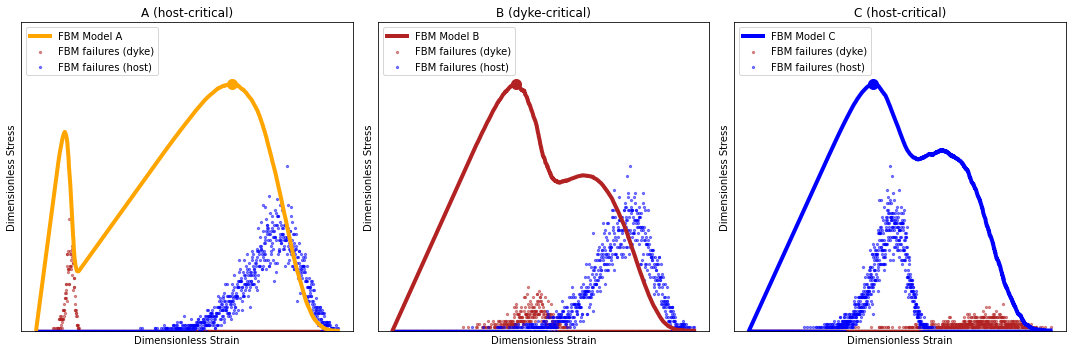

In [4]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
color = ['orange','firebrick','blue','royalblue']
alpha = [0.1,0.1,0.1]
symbol =['o','s','s']
labels = ["A (host-critical)","B (dyke-critical)","C (host-critical)"]

for i,_ax in enumerate(ax.ravel()):
    _rS = rS[i] #strength ratio
    _rE = rE[i] #elastic ratio
    
    #run FBM model
    stress,strain,ae_A,ae_B = FBM2C(1/_rE,1/_rS,f,r=0.001,N=10000)
    
    #normalise
    stress = stress / np.max(stress)
    strain = strain / np.max(strain)
    
    #plot loading curve
    _ax.plot(strain,stress,lw=4,
               color=color[i],
               label="FBM Model %s" % names[i],
               linestyle='-')
    _ax.scatter(strain[np.argmax(stress)],np.max(stress),color=color[i],s=100)
    
    #plot AE
    nf = 1 / (1.5*np.max( [ae_A,ae_B] )) #normalizing factor 
    _ax.scatter(strain,ae_A*nf,color='firebrick',alpha=0.5,s=5,label="FBM failures (dyke)")
    _ax.scatter(strain,ae_B*nf,color='b',alpha=0.5,s=5,label="FBM failures (host)")
    
    #other axes params
    #_ax.set_title(labels[i],x=0.15)
    _ax.legend(loc='upper left')
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.set_ylim(0,1.25)

    _ax.set_xlabel("Dimensionless Strain")
    _ax.set_xlabel("Dimensionless Strain")
    _ax.set_ylabel("Dimensionless Stress")
    _ax.set_ylabel("Dimensionless Stress")
    _ax.set_title(labels[i])
fig.tight_layout()
fig.show()

### Mohr-Coulomb Strength

To incorporate the mohr-coulomb failure envelope for comparison with the micromechanics theory and Irazu models, it is easier to use a dimensionalised model. In this model we also introduce an exponent **a** that allows fibers to fail multiple times (becoming less stiff each time).

In [5]:
#define host-rock properties
Ehost = 2e9
v_host = 0.25
Ghost = Ehost / (2*(1+v_host))
Chost = 2e6 #host cohesion
Fhost = np.tan(np.deg2rad(30)) #host friction coefficient

#define constant dyke properties
v_dyke = 0.25
Fdyke = np.tan(np.deg2rad(40)) #dyke friction coefficient

#other model properties
nS = [0.0, 10e6, 20e6] #normal stress
a = 0.0 #weakening fraction (0=zero stiffness after failure)
N = int(1e5) #number of fibers
r = 1e-5 #strain rate
fS = 0.05 #final strain (if no failure first)
f = 0.1 #proportion of dykes
params = dict(normal_stress = nS, a = a, N = N, r = r, final_strain = fS)

In [6]:
def FBM_Dyke(**kwds):
    """
    Scaled 2-component strain-controlled fiber bundle model assuming linear-elastic behaviour and a mohr-coulomb failure envelope. Exponent **a**
    allows dyke fibers to have residual stiffness (if it is > 0). All units are in Pa. 

    **Arguments**:
     - E_A = the elastic ratio of component A (dykes)
     - v_A = the poissons ratio of component A (dykes)
     - c_A = the cohesion of component A (dykes)
     - F_A = the friction coefficient of component A (dykes)

     - E_B = the elastic ratio of component B (host)
     - v_B = the poissons ratio of component B (host)
     - c_B = the cohesion of component B (host)
     - F_B = the friction coefficient of component B (host)

     - f = the volume fraction of component A
     - normal_stress = the externally applied bulk normal stress. Default is 0. 
     - a = the residual stiffness proportion. Post failure propertes E* and G* will be aE and aG respectively. Default is 0. 
     - final_strain = the final strain in the model. 
    **Keywords**:
     - r = The strain-rate
     - N = the number of fibres in the bundle
     - k = the shape parameter of the Weibul distribution to sample fibre cohesion from. 
    **Returns**:
     - stress = the bulk stress
     - strain = the strain
     - ae_A = the number of failures of material A
     - ae_B = the number of failures of material B
    """
    
    #get elastic and strength properties
    E_A = kwds["E_A"]
    v_A = kwds["v_A"]
    c_A = kwds["c_A"]
    phi_A = kwds["F_A"]
    E_B = kwds["E_B"]
    v_B = kwds["v_B"]
    c_B = kwds["c_B"]
    phi_B = kwds["F_B"]
    f = kwds["f"]
    k = kwds.get("k",10) #shape parameter of weibull distribution
    
    #get simulation properties
    r = kwds.get("r",0.01)
    N = kwds.get("N",int(1e6))
    nA = int(N*f) #number of fibres of type A
    nS = kwds.get("normal_stress",0) #applied bulk normal stress
    a = kwds.get("a",0)
    final_strain = kwds.get("final_strain",0.1)
    
    #calculate shear modulii
    G_A = E_A/(2*(1+v_A))
    G_B = E_B/(2*(1+v_B))

    #generate stiffness population
    G = np.hstack([  [G_A]*nA, #A-type fibers
                             [G_B]*(N-nA)]  )  #B-type fibers
    E = np.hstack([  [E_A]*nA, #A-type fibers
                             [E_B]*(N-nA)]  )  #B-type fibers
    
    #generate cohesion and friction angle population
    Fc = np.hstack([  [np.tan(phi_A)]*nA, #A-type fibers
                             [np.tan(phi_B)]*(N-nA)]  )  #B-type fibers
    C = np.hstack([  np.random.weibull(k,size=nA)*c_A, #A-type fibers
                            np.random.weibull(k,size=N-nA)*c_B]  )  #B-type fibers
    
    intact = np.array([True] * N) #store which fibers have broken
    
    #setup output vars
    strain = []
    stress = []
    ae_A = []
    ae_B = []
    
    #run FBM
    for _s in np.arange(0,final_strain,r):
        
        if np.sum(intact) == 0:
            break #get out of jail free
            
        strain.append(_s)
        
        
        #calculate per-fiber normal stress based on bulk normal stress
        E_bulk = np.mean(E)
        normal_stress = E * (nS/E_bulk)
        
        #calculate per-fiber shear stress based on applied shear-strain
        shear_stress = G * strain[-1]
        
        #calculate per-fiber strength using mohr-coulomb failure envelope
        strength = C + normal_stress*Fc
        
        #store ae
        ae_A.append( np.sum( shear_stress[0:nA] > strength[0:nA] ))
        ae_B.append( np.sum( shear_stress[nA:] > strength[nA:] ))
        
        #break fibers
        G[shear_stress>strength] = a * G[shear_stress>strength]
        #G[0:nA][shear_stress[0:nA]>strength[0:nA]] = 0 #break dyke fibers
        #G[nA:][shear_stress[nA:]>strength[nA:]] = a*G[nA:][shear_stress[nA:]>strength[nA:]]
            
        intact[shear_stress>strength] = False
        
        #store bulk shear stress
        stress.append(np.sum(G*strain[-1])/N)
        #stress.append(np.sum(_stress)/N)
        
    #done!
    return np.array(stress),np.array(strain),np.array(ae_A),np.array(ae_B)

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/3812818048.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


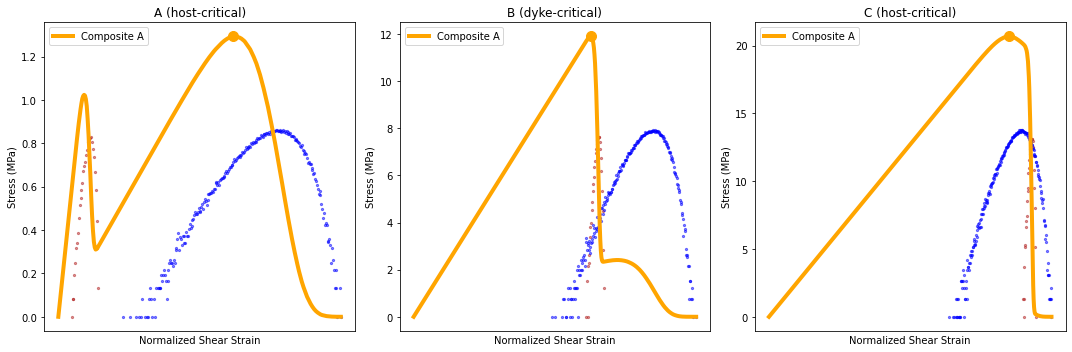

In [7]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
color = ['orange','firebrick','blue','royalblue']
backcolor = [mpl.colors.to_rgba('r'),
             mpl.colors.to_rgba('r'),
             mpl.colors.to_rgba('b')]
symbol =['o','s','s']
labels = ["A (host-critical)","B (dyke-critical)","C (host-critical)"]

for i,(_ax,_ns) in enumerate(zip(ax.ravel(), nS)):
    m = 0
    _rS = rS[m] #strength ratio
    _rE = rE[m] #elastic ratio
    
    #calculate dyke properties from these ratios
    Edyke = Ehost / _rE
    Gdyke = Edyke / (2*(1+v_dyke))
    Cdyke = Chost / _rS
    
    #run FBM model
    params['normal_stress'] = _ns

    stress,strain,ae_A,ae_B = FBM_Dyke( E_A = Edyke, v_A = v_dyke, c_A = Cdyke, F_A = Fdyke, #dyke properties
                                        E_B = Ehost, v_B = v_host, c_B = Chost, F_B = Fhost, #host properties
                                        f = f, **params )#other run properties
    
    stress /= 1e6 #convert to MPa
    strain = strain / np.max(strain) #convert to percent

    #plot loading curve
    _ax.plot(strain,stress,lw=4,
               color=color[m],
               label="Composite %s" % names[m],
               linestyle='-')
    _ax.scatter(strain[np.argmax(stress)],np.max(stress),color=color[m],s=100)
    
    #plot AE
    nf = np.max(stress) / (1.5*np.log(np.max( [ae_A,ae_B] ))) #normalizing factor 
    _ax.scatter(strain[ae_A>0],np.log(ae_A[ae_A>0])*nf,color='firebrick',alpha=0.5,s=5)
    _ax.scatter(strain[ae_B>0],np.log(ae_B[ae_B>0])*nf,color='b',alpha=0.5,s=5)
    
    _ax.set_xticks([])

    _ax.legend(loc='upper left')
    _ax.set_xlabel("Normalized Shear Strain")
    _ax.set_xlabel("Normalized Shear Strain")
    _ax.set_ylabel("Stress (MPa)")
    _ax.set_ylabel("Stress (MPa)")
    _ax.set_title(labels[i])
fig.tight_layout()
fig.show()

**Figure 2.** Fibre bundle models of shear failure in a weak layer under strain-controlled conditions and using rock properties scaled to match part A of the previous figure. Note that the differing friction angles between the host-rock and dyke results in a change in their corresponding strength ratio, and hence the stability of the (otherwise identical) system, at different confining pressures.

## Load controlled

In [8]:
def FBM_Dyke_LC(**kwds):
    """
    A 2-component stress-controlled fiber bundle model assuming linear-elastic behaviour and a mohr-coulomb failure envelope. Exponent **a**
    allows dyke fibers to have residual stiffness (if it is > 0). All units are in Pa. 

    **Arguments**:
     - E_A = the elastic ratio of component A (dykes)
     - v_A = the poissons ratio of component A (dykes)
     - c_A = the cohesion of component A (dykes)
     - F_A = the friction coefficient of component A (dykes)

     - E_B = the elastic ratio of component B (host)
     - v_B = the poissons ratio of component B (host)
     - c_B = the cohesion of component B (host)
     - F_B = the friction coefficient of component B (host)

     - f = the volume fraction of component A
     - normal_stress = the externally applied bulk normal stress. Default is 0. 
     - a = the residual stiffness proportion. Post failure G* will be aG. Default is 0. Note also that this only applies to material B.
     - final_strain = the final strain in the model. 
    **Keywords**:
     - N = the number of fibres in the bundle
     - k = the shape parameter of the Weibul distribution to sample fibre cohesion from. 
    **Returns**:
     - stress = the bulk stress
     - strain = the strain
     - ae_A = the number of failures of material A
     - ae_B = the number of failures of material B
    """
    
    #get elastic and strength properties
    E_A = kwds["E_A"]
    v_A = kwds["v_A"]
    c_A = kwds["c_A"]
    phi_A = kwds["F_A"]
    E_B = kwds["E_B"]
    v_B = kwds["v_B"]
    c_B = kwds["c_B"]
    phi_B = kwds["F_B"]
    f = kwds["f"]
    k = kwds.get("k",10) #shape parameter of weibull distribution
    
    #get simulation properties
    r = kwds.get("r",1e3)
    N = kwds.get("N",int(1e6))
    nA = int(N*f) #number of fibres of type A
    nS = kwds.get("normal_stress",0) #applied bulk normal stress
    a = kwds.get("a",0)
    final_strain = kwds.get("final_strain",0.1)

    #calculate shear modulii
    G_A = E_A/(2*(1+v_A))
    G_B = E_B/(2*(1+v_B))

    #generate stiffness population
    G = np.hstack([  [G_A]*nA, #A-type fibers
                             [G_B]*(N-nA)]  )  #B-type fibers
    E = np.hstack([  [E_A]*nA, #A-type fibers
                             [E_B]*(N-nA)]  )  #B-type fibers
    
    #generate cohesion and friction angle population
    Fc = np.hstack([  [np.tan(phi_A)]*nA, #A-type fibers
                             [np.tan(phi_B)]*(N-nA)]  )  #B-type fibers
    C = np.hstack([  np.random.weibull(k,size=nA)*c_A, #A-type fibers
                            np.random.weibull(k,size=N-nA)*c_B]  )  #B-type fibers
    
    intact = np.array([True] * N) #store which fibers have broken
    
    #calculate per-fiber normal stress based on bulk normal stress
    E_bulk = np.mean(E)
    normal_stress = E * (nS/E_bulk)
            
    #calculate per-fiber strength using mohr-coulomb failure envelope
    strength = C + normal_stress*Fc
        
    #calculate per-fiber failure strains
    fstrain = strength / G
    
    #setup output vars
    strain = []
    stress = []
    ae_A = []
    ae_B = []
    
    #run FBM
    _load = 0
    _strain = 0
    nn=0
    while np.sum(intact) > 0 and _strain < final_strain:
        
        #find the load at which the next fiber breaks
        _load = np.min(fstrain)*np.mean(G)
        
        #increment load
        _load += r
        
        #iterate until equillibrium is reached (or total system failure)
        _ae_A = 0
        _ae_B = 0
        _strain = _load/np.mean(G) #calculate bulk strain
        shear_stress = G * _strain #calculate per-fiber shear stress based on applied shear-strain
        while np.any(shear_stress>=strength):
            #store ae
            _ae_A += np.sum( shear_stress[0:nA] > strength[0:nA] )
            _ae_B += np.sum( shear_stress[nA:] > strength[nA:])
        
            #break fibers
            G[0:nA][shear_stress[0:nA]>strength[0:nA]] = 0 #break dyke fibers
            G[nA:][shear_stress[nA:]>strength[nA:]] = a*G[nA:][shear_stress[nA:]>strength[nA:]]
            #G[shear_stress>strength] = a * G[shear_stress>strength]
            fstrain[shear_stress>strength] = np.inf
            intact[shear_stress>strength] = False
            
            #update stress calculations and iterate
            if np.sum(intact>0):
                _strain = _load/np.mean(G)
                shear_stress = G * _strain
            else:
                #done!
                #strain.append(_strain)
                return np.array(stress),np.array(strain),np.array(ae_A),np.array(ae_B)
        
        #store data
        strain.append(_load/np.mean(G)) 
        stress.append(_load)
        ae_A.append(_ae_A)
        ae_B.append(_ae_B)

In [9]:
#define host-rock properties
Ehost = 2e9
v_host = 0.25
Ghost = Ehost / (2*(1+v_host))
Chost = 1e6 #host cohesion
Fhost = np.tan(np.deg2rad(35)) #host friction coefficient

#define constant dyke properties
v_dyke = 0.25
Fdyke = np.tan(np.deg2rad(30)) #dyke friction coefficient

#other model properties
nS = 20e6 #normal stress
a = 0.0 #weakening fraction (0=zero stiffness after failure)
N = int(1e7) #int(1e5) #number of fibers
r = 1e-5 #strain rate
fS = 0.05 #final strain (if no failure first)
f=0.05 #proportion of dykes
params = dict(normal_stress = nS, a = a, N = N, r = r, final_strain = fS)

_rS = 1/20#rS[i] #strength ratio
_rE = 1/25#rE[i] #elastic ratio

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/2626084252.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/2626084252.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


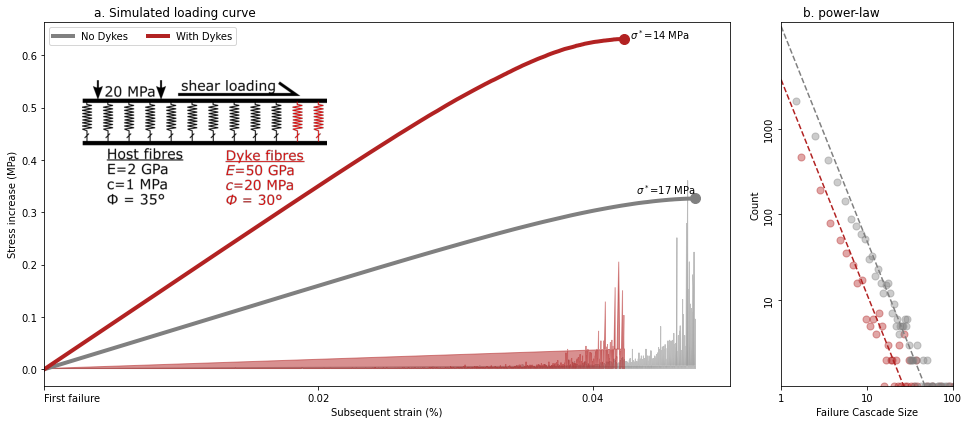

In [10]:
recalculate = False #set to true to re-run the model (can take several hours for large N)

fig,ax = plt.subplots(1,2,figsize=(17,6))
color = ['orange','firebrick','blue','royalblue']
backcolor = [mpl.colors.to_rgba('r'),
             mpl.colors.to_rgba('r'),
             mpl.colors.to_rgba('b'),
             mpl.colors.to_rgba('b')]
alpha = [0.1,0.1,0.1,0.1]
symbol =['o','s','s','o']
labels = ["A (host-critical)","B (dyke-critical)","C (host-critical)","D (dyke-critical)"]

#run  model with no dykes (control)
if recalculate:
    stress_control,strain_control,_,ae_control = FBM_Dyke_LC( E_A = Ehost, v_A = v_host, c_A = Chost, F_A = Fhost,
                                        E_B = Ehost, v_B = v_host, c_B = Chost, F_B = Fhost, 
                                        f=0.0, **params)
    np.save("control",np.array([stress_control,strain_control,ae_control,ae_control])) #save
    print("Control model complete.")
else:
    stress_control,strain_control,_,ae_control = np.load('control.npy')
    
#normalise
maxS_control = np.max(stress_control)
stress_control -= stress_control[0]
strain_control -= strain_control[0]
stress_control /= 1e6 #convert to MPa
strain_control = strain_control * 100 #convert to percent

#run model with dykes
Edyke = Ehost / _rE
Gdyke = Edyke / (2*(1+v_dyke))
Cdyke = Chost / _rS
if recalculate:
    stress,strain,ae_A,ae_B = FBM_Dyke_LC( E_A = Edyke, v_A = v_dyke, c_A = Cdyke, F_A = Fdyke, #dyke properties
                                        E_B = Ehost, v_B = v_host, c_B = Chost, F_B = Fhost, #host properties
                                        f = f, **params )#other run properties
    np.save("dyke",np.array([stress,strain,ae_A,ae_B])) #save
    print("Dyke model complete.")
else:
    stress,strain,ae_A,ae_B = np.load('dyke.npy')

#add host failures to ae_A
ae_A = ae_A+ae_B

#normalise
maxS = np.max(stress)
stress -= stress[0]
strain -= strain[0]
stress /= 1e6 #convert to MPa
strain = strain * 100 #convert to percent

#plot control curve
ax[0].plot(strain_control,stress_control,lw=4,
           color='gray',
           label="No Dykes",
           linestyle='-')
nf = np.max(stress) / (1.75*np.max( np.hstack([ae_A,ae_B,ae_control]))) #normalizing factor 
ax[0].fill(strain_control,ae_control*nf,color='gray',alpha=0.5)
ax[0].scatter(strain_control[np.argmax(stress_control)],np.max(stress_control),color='grey',s=100)

#plot loading curve
ax[0].plot(strain,stress,lw=4,
           color='firebrick',
           label="With Dykes",
           linestyle='-')
ax[0].scatter(strain[np.argmax(stress)],np.max(stress),color='firebrick',s=100)
ax[0].fill(strain,ae_A*nf,color='firebrick',alpha=0.5)

#plot yield stress
ax[0].text(np.max(strain_control),np.max(stress_control)+0.005,r"$\sigma^*$=%d MPa" % (maxS_control/1e6),
        verticalalignment='bottom',horizontalalignment='right')
ax[0].text(np.max(strain),np.max(stress),r"  $\sigma^*$=%d MPa" % (maxS/1e6))

ax[0].legend(loc='upper left',ncol=2)
ax[0].set_xlabel("Subsequent strain (%)")
ax[0].set_ylabel("Stress increase (MPa)")
ax[0].set_xticks([0,0.02,0.04])
ax[0].set_xticklabels(['First failure','0.02','0.04'])
ax[0].xaxis.get_ticklabels()[0].set_horizontalalignment('left')
    
ax[0].set_xlim(0,0.05)

#plot power-law distribution
for i,_ae in enumerate([ae_A,ae_control]):
    size = np.linspace(0,np.max(_ae),500)
    ds = size[1]-size[0]
    count = np.array([np.sum( np.logical_and(_ae > s,_ae < s+ds)) for s in size])

    mask=count>0
    logS = np.log10((size[mask]))
    logF = np.log10(count[mask])

    ax[1].scatter(logS,logF,color=['firebrick','grey'][i],alpha=0.4,s=50)

    #plot trend line
    m = -5/2
    c = np.median(logF) - m * np.median(logS)
    _x = np.array([0,3])
    ax[1].plot(_x,m*_x+c,color=['firebrick','grey'][i],linestyle='--')

ax[1].set_yticks([1,2,3])
ax[1].set_yticklabels(['10','100','1000'])
ax[1].tick_params(axis='y', rotation=90)
for l in ax[1].yaxis.get_ticklabels():
    l.set_verticalalignment('center')
    
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['1','10','100'])
ax[1].set_aspect('equal')
ax[1].set_xlim(0,2.0)
ax[1].set_ylim(np.min(logF)*0.99,np.max(logF)*1.05)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Failure Cascade Size")

#plot model outline
ax1 = fig.add_axes([0.07, 0.36, 0.2, 0.6]) #curve A
img = plt.imread("FBM_1.png")
ax1.imshow(img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')

ax[0].set_title("a. Simulated loading curve",x=0.19)
ax[1].set_title("b. power-law",x=0.35)
fig.tight_layout()
fig.subplots_adjust(wspace=-0.3, hspace=0)

fig.show()

**Figure 3.** Loading curves (a) for a weak layer crosscut by 5% dykes (red) and with no dykes (grey) simulated using a linear-elastic fibre bundle model containing 10^7 fibres. Note that to allow plotting on the same figure, stresses and strains are normalised by their values at the initial failure event. Somewhat counterintuitively, the stiffening effect of the dykes causes global failure at lower stress than the model with no dykes. Load redistribution after each failure can trigger failure cascades (histograms in (a)) that are analogous to seismic events and show a power-law distribution (b) with slope -5/2 (dashed lines). The number of failure events prior to catastrophic collapse is ~1 order of magnitude less when dykes are involved, suggesting more limited precursor activity. 

## Visco-elastic host rock

In [11]:
def FBM_Maxwell(**kwds):
    """
    A 2-component stress-controlled fiber bundle model assuming linear-elastic behavior for dyke fibers and Maxwell visco-elastic
    behavior for host fibers. Both fibers are assumed to have constant yield stresses calculated using the mohr-coulomb failure
    criterion and normal stresses that are proportional to the stiffness ratio (and are calculated prior to running the model).
    **Arguments**:
     - E_A = the elastic ratio of component A (dykes)
     - v_A = the poissons ratio of component A (dykes)
     - c_A = the cohesion of component A (dykes)
     - F_A = the friction coefficient of component A (dykes)

     - E_B = the elastic ratio of component B (host)
     - v_B = the poissons ratio of component B (host)
     - mu_B = the (Maxwell) viscocity of the host rock
     - c_B = the cohesion of component B (host)
     - F_B = the friction coefficient of component B (host)

     - f = the volume fraction of component A
     - normal_stress = the externally applied bulk normal stress. Default is 0. 
     - ts = the timestep of the model (in years). Default is 10.
     - final_time = how long to run the model for (in years)
    **Keywords**:
     - N = the number of fibres in the bundle
     - k = the shape parameter of the Weibul distribution to sample fibre cohesion from. 
    **Returns**:
     - stress = the bulk stress
     - strain = the strain
     - ae_A = the number of failures of material A
     - ae_B = the number of failures of material B
    """
    
    #get elastic and strength properties
    E_A = kwds["E_A"]
    v_A = kwds["v_A"]
    c_A = kwds["c_A"]
    phi_A = kwds["F_A"]
    E_B = kwds["E_B"]
    v_B = kwds["v_B"]
    mu_B = kwds["mu_B"]
    c_B = kwds["c_B"]
    phi_B = kwds["F_B"]
    f = kwds["f"]
    k = kwds.get("k",10) #shape parameter of weibull distribution
    
    #get simulation properties
    r = kwds.get("r",1e3)
    N = kwds.get("N",int(1e6))
    nA = int(N*f) #number of fibres of type A
    nS = kwds.get("normal_stress",0) #applied bulk normal stress
    load = kwds.get("shear_stress",5e6) #applied shear stress
    ts = kwds.get("ts",0.25)*3.154e7 #timestep (in seconds)
    final_time = kwds.get("final_time",500)*3.154e7 #when to stop model (in seconds)

    #calculate shear modulii
    G_A = E_A/(2*(1+v_A))
    G_B = E_B/(2*(1+v_B))

    #generate stiffness population
    G = np.hstack([  [G_A]*nA, #A-type fibers
                             [G_B]*(N-nA)]  )  #B-type fibers
    E = np.hstack([  [E_A]*nA, #A-type fibers
                             [E_B]*(N-nA)]  )  #B-type fibers
    
    #generate cohesion and friction angle population
    Fc = np.hstack([  [np.tan(phi_A)]*nA, #A-type fibers
                             [np.tan(phi_B)]*(N-nA)]  )  #B-type fibers
    C = np.hstack([  np.random.weibull(k,size=nA)*c_A, #A-type fibers
                            np.random.weibull(k,size=N-nA)*c_B]  )  #B-type fibers
    #C = np.hstack( [[c_A]*nA,[c_B]*(N-nA)])
    
    intact = np.array([True] * N) #store which fibers have broken
    
    #calculate per-fiber normal stress based on bulk normal stress
    E_bulk = np.mean(E)
    normal_stress = E * (nS/E_bulk)
            
    #calculate per-fiber yield stress using mohr-coulomb failure envelope
    strength = C + normal_stress*Fc
    
    #setup output vars
    strain = [] #total strain
    time = [] #time-steps
    ae_A = []
    ae_B = []
    
    #calculate initial state by applying instantaneous load (aka use the purely elastic solution)
    _strain = load/np.mean(G)
    shear_stress = G*_strain
    _ae_A = 0
    _ae_B = 0
    while np.any(shear_stress>strength):
        #store ae
        _ae_A += np.sum( shear_stress[0:nA] > strength[0:nA] )
        _ae_B += np.sum( shear_stress[nA:] > strength[nA:])
    
        #break fibers
        G[shear_stress>strength] = 0 #break fibers
        intact[shear_stress>strength] = False
           
        #update stress calculations and iterate
        if np.sum(intact>0):
            _strain = load/np.mean(G)
            shear_stress = G * _strain
        else:
            print("Warning: the FBM failed catastrophically in its initial state.")
            return np.array([0]),np.array([0]),np.array([0]),np.array([0]),(strength[:nA],strength[nA:])
        
        
    #store initial state
    time.append(0)
    strain.append(_strain) 
    ae_A.append(_ae_A)
    ae_B.append(_ae_B)
    
    #simulate viscous strain in Maxwell fibers and associated load redistribution
    _t = 0
    _viscous_strain = 0 #permanent strain
    while (_t < final_time):
        _ae_A = 0
        _ae_B = 0
        _t += ts #time in seconds
        
        #calculate permanent (viscous) strain of intact host-fibers
        stress_B = (_strain-_viscous_strain)*G_B #stress on host fibers
        _viscous_strain += (stress_B/mu_B)*ts #resulting viscous strain (assuming constant stress)
        
        #redistribute stresses
        stable = False
        while not stable:
            
            #calculate fraction of intact dyke and host fibers
            fA = np.sum(intact[0:nA]) / N
            fB = np.sum(intact[nA:]) / N
            
            #calculate bulk strain
            _strain = (load + G_B*fB*_viscous_strain) / (G_A*fA + G_B*fB)
            
            #check it
            stress_A = _strain * G_A
            stress_B = (_strain - _viscous_strain)*G_B
            assert np.abs((fA*stress_A + fB*stress_B) - load) < 1e-6, "Error - loads do not balance."
            
            #break fibers
            broken_A = G[0:nA]*_strain > strength[0:nA]
            broken_B = G[nA:]*(_strain-_viscous_strain) > strength[nA:]
            G[0:nA][broken_A] = 0
            G[nA:][broken_B] = 0
            intact = G > 0
            _ae_A += np.sum(broken_A)
            _ae_B += np.sum(broken_B)
            
            #is this a stable state or do we need to iterate again?
            stable = (np.sum(broken_A) + np.sum(broken_B)) == 0

            #have all the fibers broken? (emergency exit!)
            if np.sum(intact) == 0:
                print("FBM failed catastrophically after %d years" % (_t/3.154e7))
                return np.array(time)/3.154e7,np.array(strain),np.array(ae_A),np.array(ae_B),(strength[:nA],strength[nA:])
            
        #store data
        time.append(_t)
        strain.append(_strain) 
        ae_A.append(_ae_A)
        ae_B.append(_ae_B)
    
    #print mean rock properties
    #print("Dyke Yield Stress = %.2f MPa" % (np.mean(strength[:nA])/1e6))
    #print("Host Yield Stress = %.2f MPa" % (np.mean(strength[nA:])/1e6))
    
    #done!
    return np.array(time)/3.154e7,np.array(strain),np.array(ae_A),np.array(ae_B), (strength[:nA],strength[nA:])

In [12]:
#define proportion of dykes
f=0.05

#define elastic ratio
_rE = 1/25

#define rock properties
Ehost = 2e9
v_host = 0.25
Ghost = Ehost / (2*(1+v_host))
mu_host = 1e17 #host rock viscocity
Cdyke = 20e6 #host rock cohesion
Fhost = np.tan(np.deg2rad(35)) #host friction coefficient
v_dyke = 0.25
Fdyke = np.tan(np.deg2rad(30)) #dyke friction coefficient

#other model properties
N = int(1e6) #number of fibers
ts = 1 #timestep (years)
final_time = 25 #2.5e3 #final time (years)
params = dict(N = N, ts = ts, final_time = final_time)

FBM failed catastrophically after 15 years
FBM failed catastrophically after 7 years


/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/377735157.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_21396/377735157.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


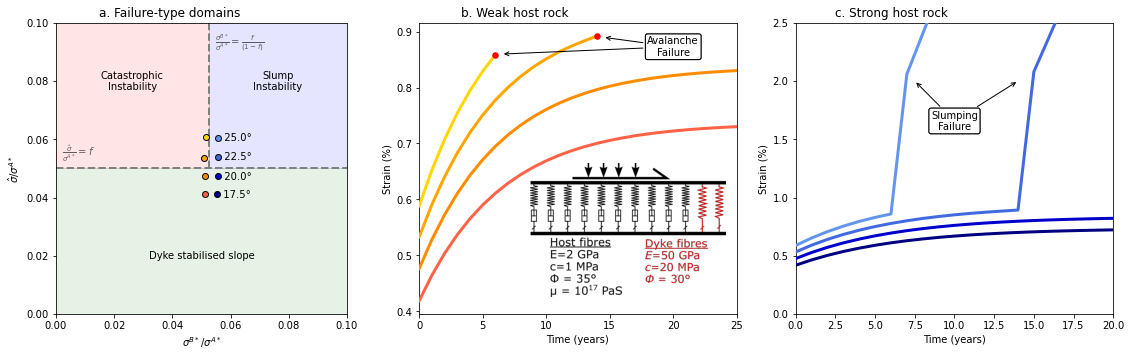

In [13]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].set_title('a. Failure-type domains',x=0.39)
ax[1].set_title("b. Weak host rock",x=0.3)
ax[2].set_title("c. Strong host rock",x=0.3)

#evaluate and plot deformation
colors = [['tomato','darkorange','orange','gold'],
           ['navy','mediumblue','royalblue','cornflowerblue']]
points = np.array([(0.05), #weak host strength ratio (dykes are 20 times stronger)
                   (0.2)]) #strong host strength ratio (dykes are 5 times stronger)
maxAE = 0
for i,p in enumerate(points):
    
    #calculate remaining rock properties
    Edyke = Ehost / _rE
    Chost = Cdyke * p

    #ax2 = ax[i+1].twinx()
    for n,dip in enumerate([17.5,20,22.5,25]): #depths to calculate stresses with
        
        #calculate normal and shear stress from overburden
        dip = np.deg2rad(dip) #weak layer dips at 22 degrees
        depth=1000
        Sv = 2500*9.8*depth #calculate overburden pressure
        Sn = Sv*np.cos(dip) #normal stress on weak layer
        Ss = Sv*np.sin(dip) #shear stress on weak layer
    
        #run model    
        time,strain,ae_A,ae_B,strength = FBM_Maxwell( E_A = Edyke, v_A = v_host, c_A = Cdyke, F_A = Fdyke, #dyke properties
                                             E_B = Ehost, v_B = v_host, mu_B=mu_host, c_B = Chost, F_B = Fhost, #host properties
                                             f = f, normal_stress = Sn, shear_stress = Ss, **params )#other run properties

        #plot position on failure type plot   
        SDyke, SHost = (np.min(strength[0]),np.min(strength[1]))
        
        ax[0].scatter( SHost / SDyke, Ss / SDyke, color=colors[i][n], edgecolors='k',zorder=10)
        if i==1: #plot dip on second set of points
            ax[0].text(SHost / SDyke,Ss / SDyke,"  %.1f°" % np.rad2deg(dip),verticalalignment='center',color='k')
        if depth==500:
            ax[0].text(SHost / SDyke,Ss / SDyke,[" A"," B"][i],verticalalignment='center',color=colors[i][n])
            
        #plot deformation
        ax[i+1].plot(time,strain*100,lw=3,color=colors[i][n],label=['A','B','C'][i],zorder=5-i)
        if np.max(time) < params['final_time']: #if there was a catastrophic failure
            ax[i+1].scatter(time[np.argmax(strain)],np.max(strain)*100,color='r',s=30,zorder=10)
    
        #plot AE
        #if np.max(ae_A) > 0:
        #    ax2.plot(time/1e3,ae_A,color=colors[i][n],lw=2)
        #    maxAE = np.max([maxAE, np.max(ae_A)])
        
    ax[i+1].set_ylabel("Strain (%)")
    ax[i+1].set_xlabel("Time (years)")
    #ax2.set_ylim(0,maxAE*4)
    #ax2.set_yticks([(maxAE/2 - (maxAE/2)%100),maxAE - maxAE%100])
    
ax[2].set_ylim(0,2.5)
ax[2].set_xlim(0,20) #2.0
ax[1].set_xlim(0,25) #2.55

#plot phase space
colors=['r','b','g']
ax[0].set_xlabel(r"$\sigma^{B*} / \sigma^{A*}$")
ax[0].set_ylabel(r"$\hat{\sigma} / \sigma^{A*}$")
ax[0].axhline(f,color='gray',linestyle='--',lw=2)
fx = f/(1-f)
ax[0].plot([fx,fx],[f,1.0],color='gray',linestyle='--',lw=2)
ax[0].fill([0,0,1,1],[0,f,f,0],color=colors[2],alpha=0.1,zorder=-1) #stable region
ax[0].fill([0,0,fx,fx],[f,1,1,f],color=colors[0],alpha=0.1,zorder=-1)
ax[0].fill([fx,fx,1,1],[f,1,1,f],color=colors[1],alpha=0.1,zorder=-1)
ax[0].set_xlim(0,0.1)
ax[0].set_ylim(0,0.1)
ax[0].set_aspect('equal')
ax[0].text((fx)/2,0.08,"Catastrophic\nInstability",horizontalalignment='center',verticalalignment='center')
ax[0].text(fx + (0.1-(fx))/2,0.08,"Slump\nInstability",horizontalalignment='center',verticalalignment='center')
ax[0].text(0.05,0.02,"Dyke stabilised slope",horizontalalignment='center',verticalalignment='center')

#plot annotations
bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=1)
ax[1].annotate("Avalanche\nFailure", xy=(6.5,0.86),xytext=(20,0.873),arrowprops=dict(arrowstyle='->'),
               verticalalignment='center',horizontalalignment='center',zorder=15,bbox=bbox_props)
ax[1].annotate("Avalanche\nFailure", xy=(14.5,0.89),xytext=(20,0.873),arrowprops=dict(arrowstyle='->'),
               verticalalignment='center',horizontalalignment='center',zorder=15,bbox=bbox_props)

ax[2].annotate("Slumping\nFailure", xy=(7.5,2.0),xytext=(10,1.75),arrowprops=dict(arrowstyle='->'),
               verticalalignment='top',horizontalalignment='center',zorder=15,bbox=bbox_props)
ax[2].annotate("Slumping\nFailure", xy=(14,2.0),xytext=(10,1.75),arrowprops=dict(arrowstyle='->'),
               verticalalignment='top',horizontalalignment='center',zorder=15,bbox=bbox_props)
ax[0].text(0.002,0.054,r"$\frac{\hat{\sigma}}{\sigma^{A*}}=f$",color='k',alpha=0.6)
ax[0].text(fx+0.002,0.092,r"$\frac{\sigma^{B*}}{\sigma^{A*}}=\frac{f}{(1-f)}$",color='k',alpha=0.6)

#plot model outline
ax1 = fig.add_axes([0.475, 0.15, 0.17, 0.4]) #curve A
img = plt.imread("FBM_2.png")
ax1.imshow(img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')


fig.tight_layout()
fig.show()

**Figure 4.** FBMs simulating creep by using Maxwell viscoelastic fibres for the host-rock. Viscous deformation of these host-fibres gradually transfers the loading onto the elastic dyke network, after which the model slopes exhibit three different behaviours (a): dyke-stabilised, catastrophic and slumping. Simulations of each of these are shown in (b) and (c) under loading equivalent to ~1 km depth and a slip surface dipping from 17.5° to 25°. In (b) the dyke network is 20 times stronger than the host-rock, so it fails at a higher load than the host-rock can support, resulting in a catastrophic collapse (debris avalanche type). Conversely, in (c) the dykes are only 5 times stronger, and so the host-rock does not fail with the dyke-network and a slump-type instability develops. Slopes of 17.5 and 20 degrees (lower two curves) are stabile in both (a) and (b). Dykes fibres comprise 5% of all of the models (f=0.05), which matches the approximate dyke volume fraction at shallow levels of the Taburiente Volcano (Thiele et al., 2019b).